In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt

2024-02-22 12:44:07.597792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 12:44:07.775439: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Load stLearn data objects

In [2]:
import pickle

with open('../data/melanoma_data.pkl', 'rb') as f:
    melanoma_data = pickle.load(f)

In [3]:
colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10]
}

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}
visium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_cci']]
cosmx_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_cci']]
xenium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_cci']]

#### Normalise each group of samples

In [5]:
visium_normalised = mmcci.it.normalise_within_tech(visium_cci, melanoma_data['visium_sizes'])
xenium_normalised = mmcci.it.normalise_within_tech(xenium_cci, melanoma_data['xenium_sizes'])
cosmx_normalised = mmcci.it.normalise_within_tech(cosmx_cci, melanoma_data['cosmx_sizes'])

#### Integrate Patients

- 6747: vis4, cosmx1
- 21031: vis2, cosmx2, cosmx3
- 48974: vis1, cosmx4, cosmx5, cosmx6
- 66487: vis3, cosmx7, cosmx8



In [6]:
p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

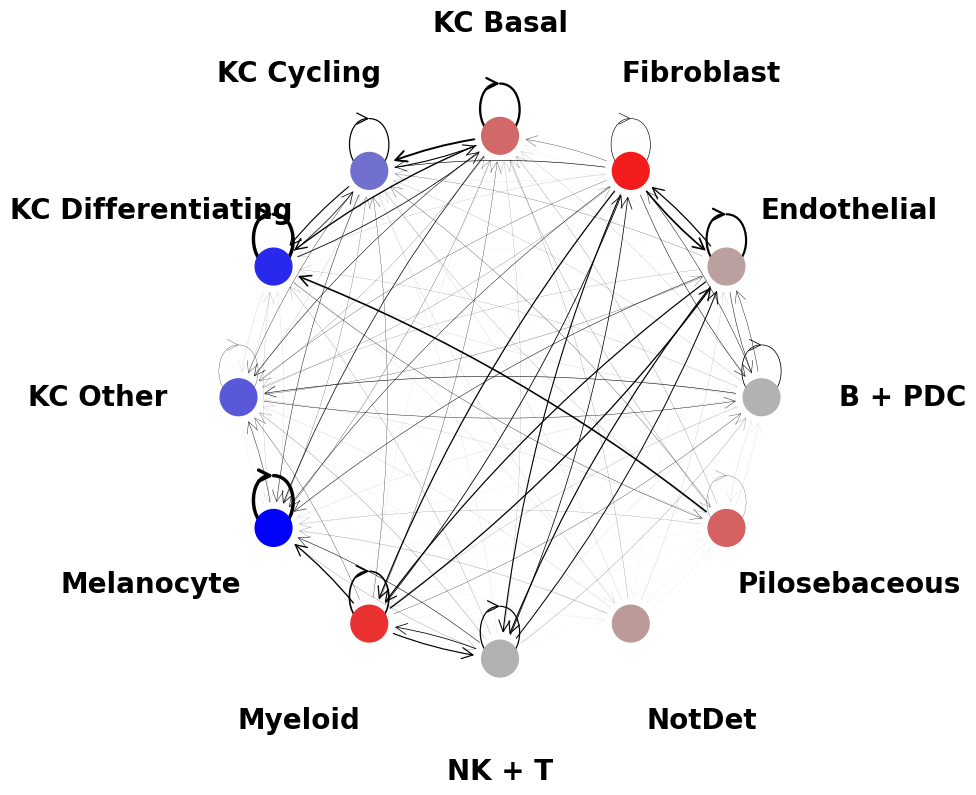

In [7]:
mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(p21031['cos'][1]), edge_weight=40, text_size=20, node_label_dist=1.1)

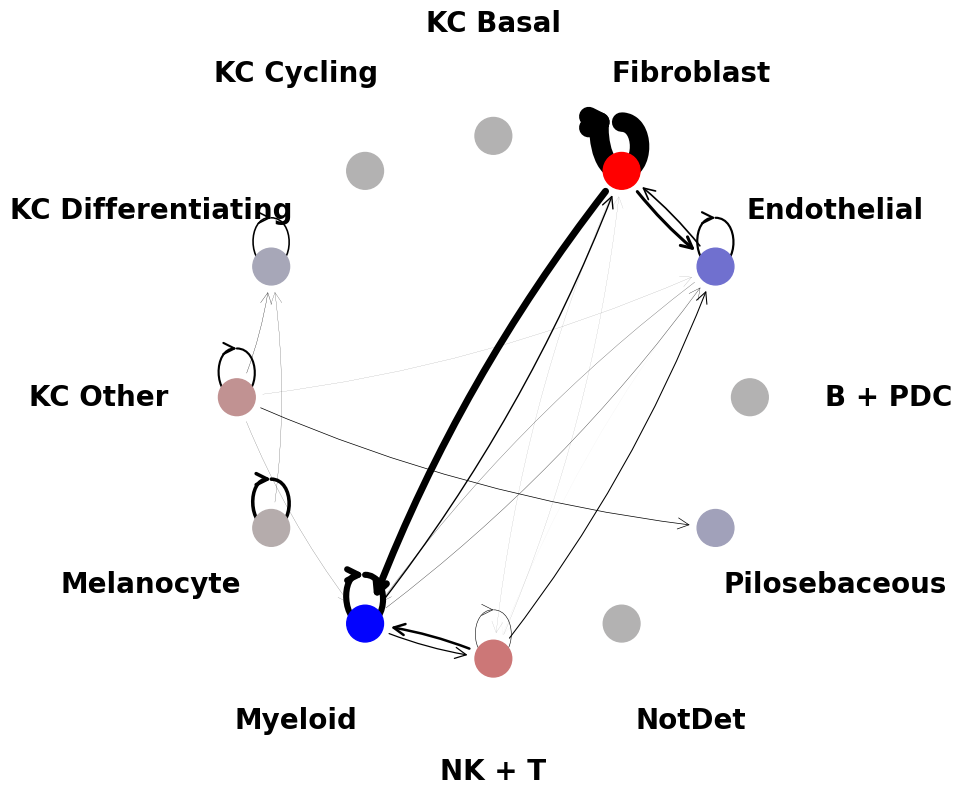

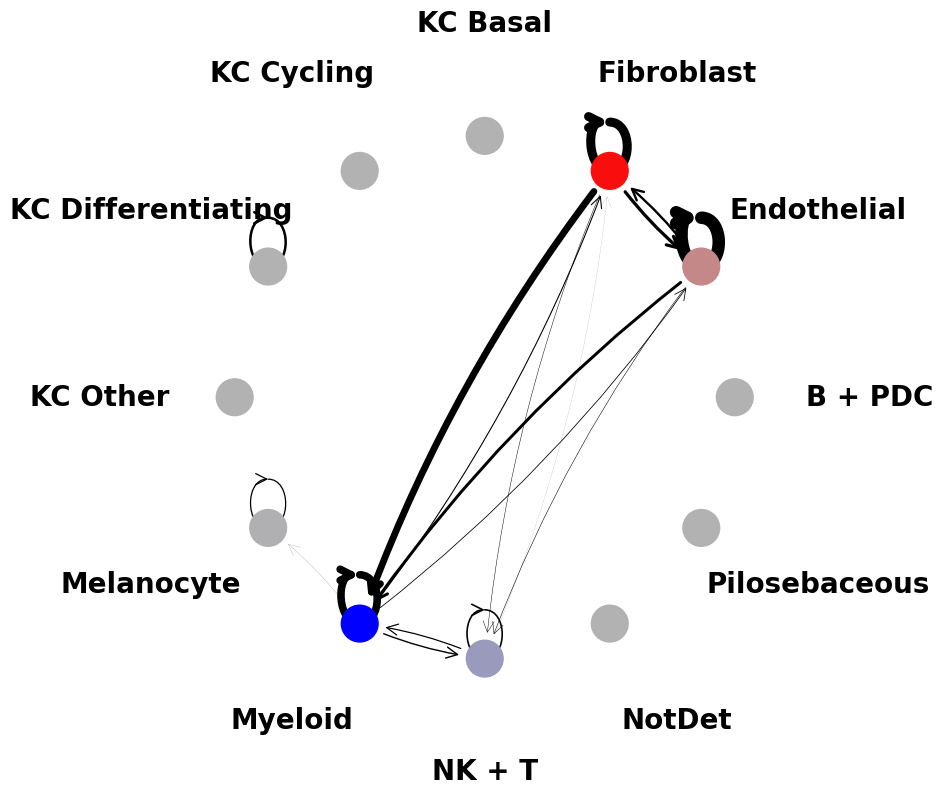

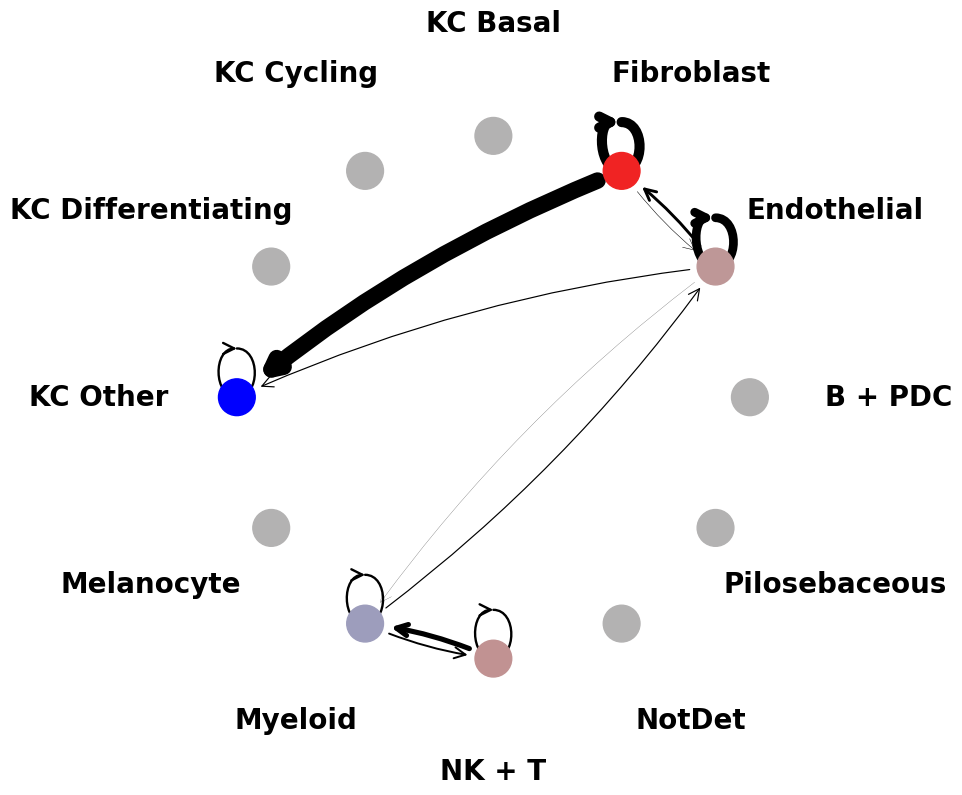

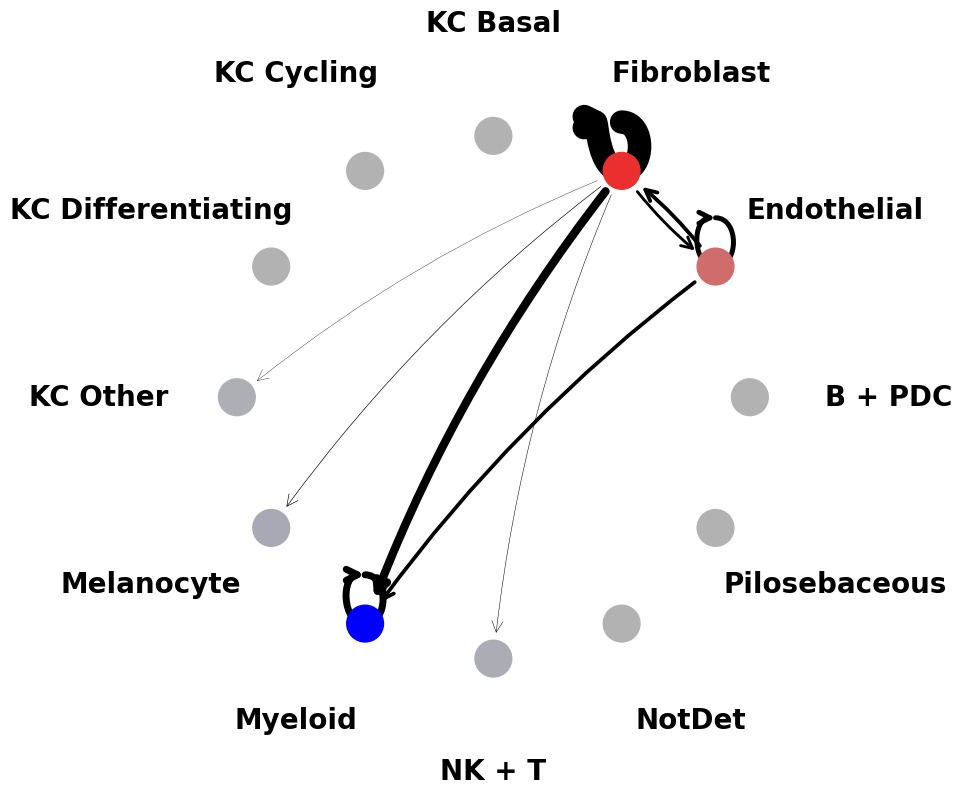

In [8]:
patient_integrated = {}

for patient, samples in patients.items():
    for tech in patients[patient].keys():
        if len(samples[tech]) >= 2:
            samples[tech] = mmcci.it.integrate_samples(samples[tech])
        else:
            samples[tech] = samples[tech][0]
    normalised = mmcci.it.normalise_between_tech([samples['vis'], samples['cos']])
    integrated = mmcci.it.integrate_samples(normalised)
    overall = mmcci.it.calculate_overall_interactions(integrated)
    # mmcci.plt.chord_plot(overall, colors=colors)
    mmcci.plt.network_plot(overall, edge_weight=40, text_size=20, node_label_dist=1.1)
    patient_integrated[patient] = integrated

#### Integrate Patients Together

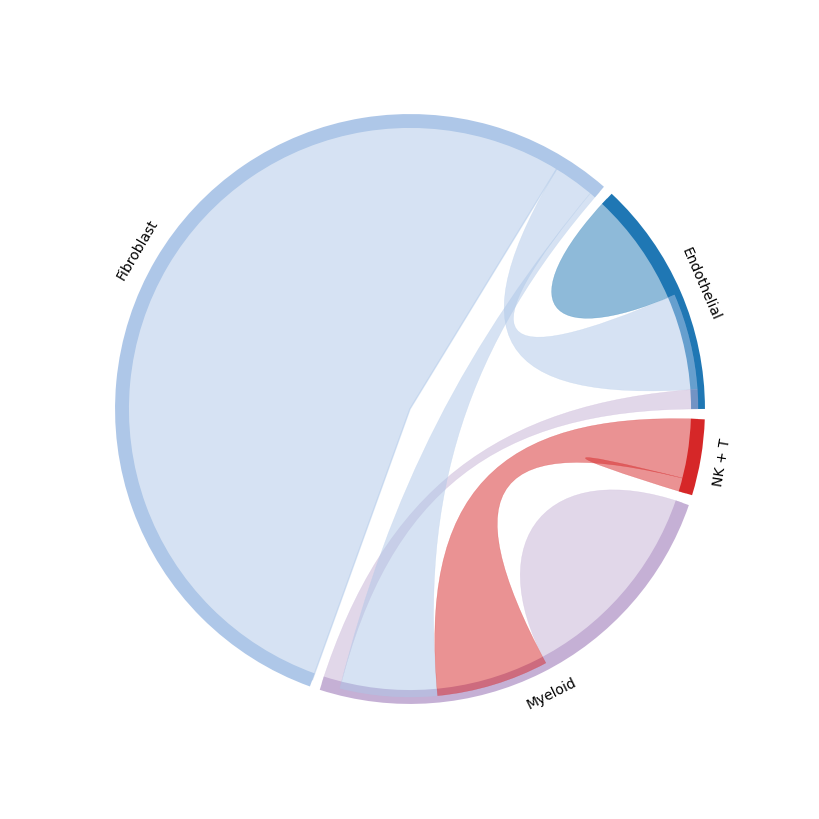

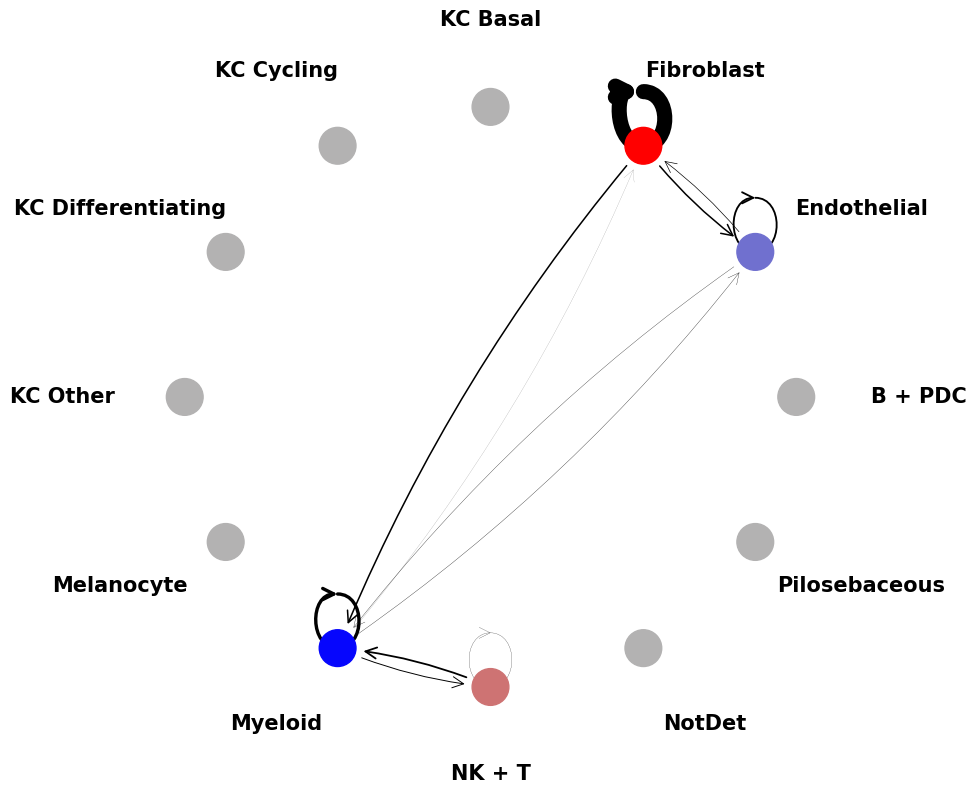

In [9]:
normalised = mmcci.it.normalise_between_tech(
    [patient_integrated['6747'], patient_integrated['21031'], patient_integrated['48974'], patient_integrated['66487']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall)

#### Integrate within tech

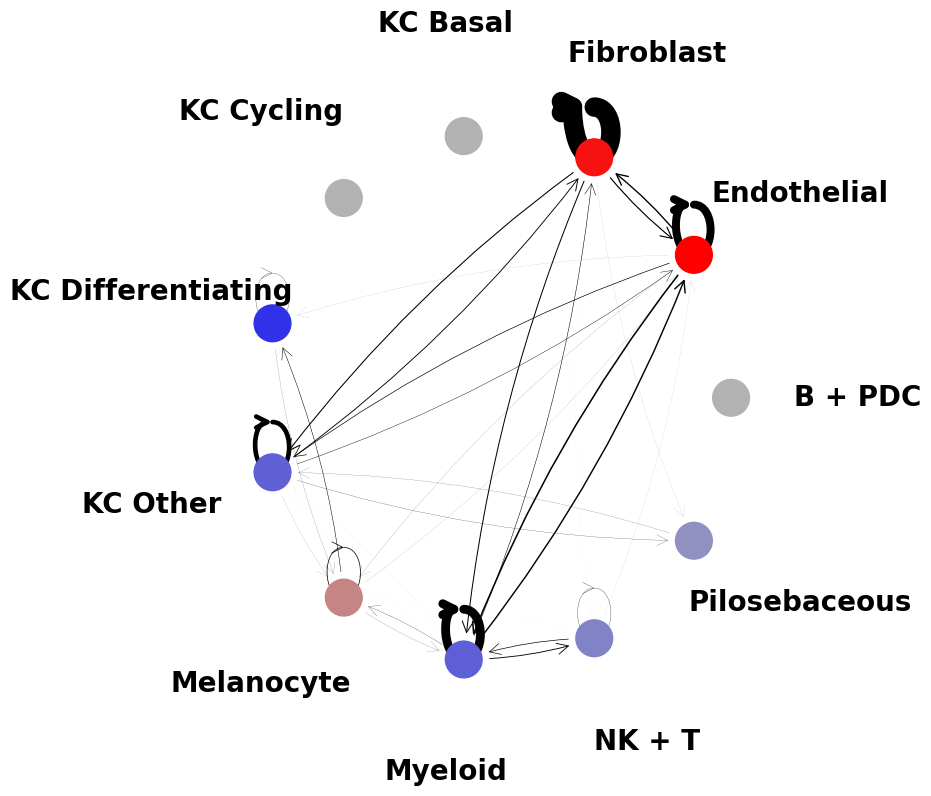

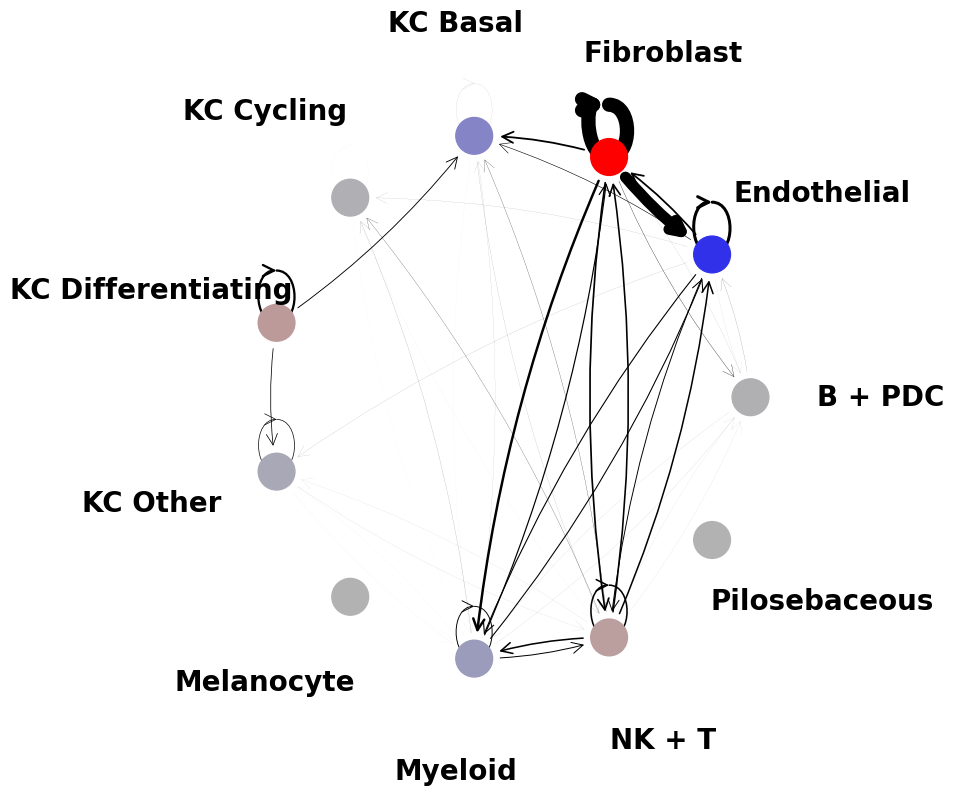

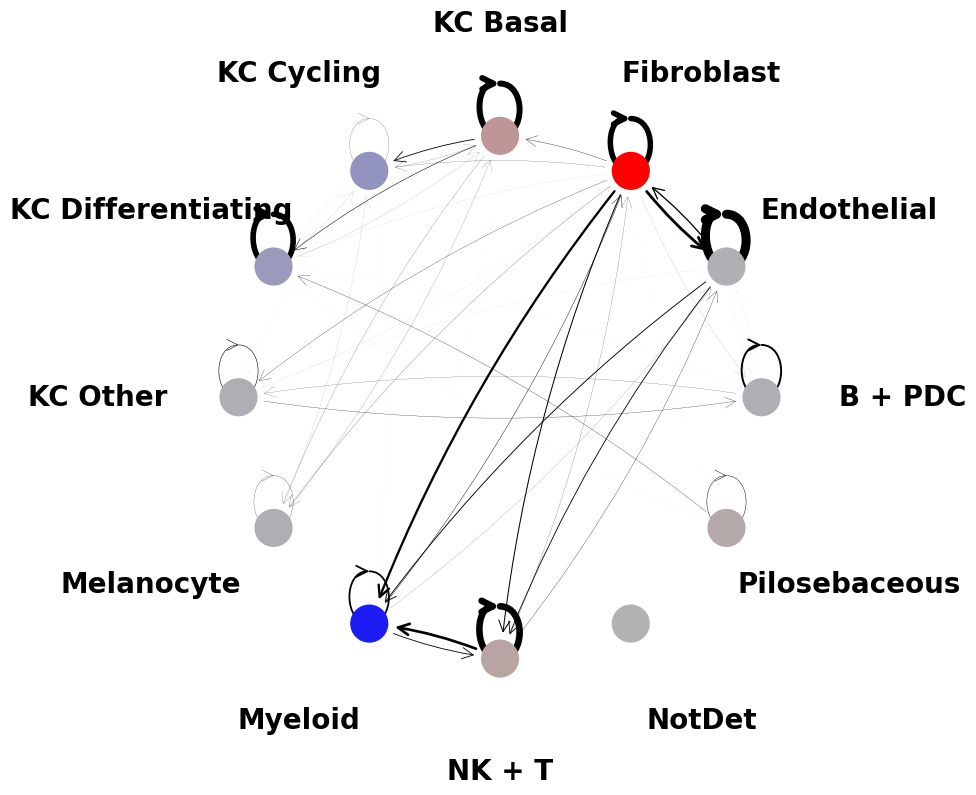

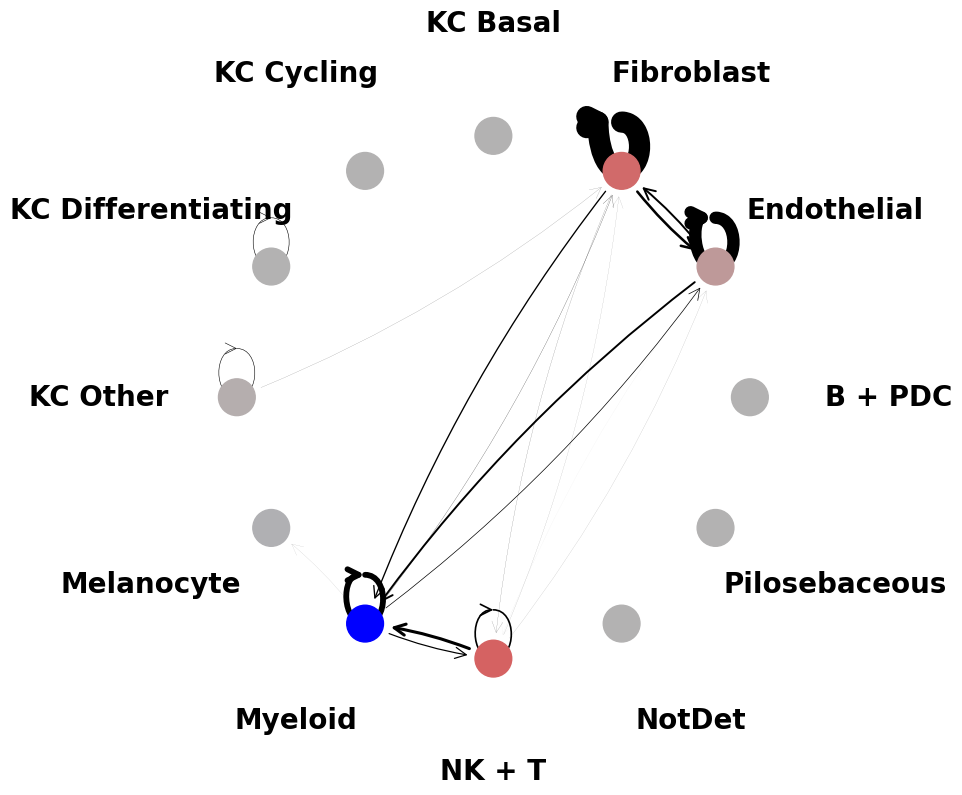

In [10]:
integrated_tech = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    integrated_tech[tech] = mmcci.it.integrate_samples(samples)
    overall[tech] = mmcci.it.calculate_overall_interactions(integrated_tech[tech])
    # mmcci.plt.chord_plot(overall[tech], colors=colors)
    mmcci.plt.network_plot(overall[tech], edge_weight=40, text_size=20, node_label_dist=1.1)
    
normalised = mmcci.it.normalise_between_tech(
    [integrated_tech['vis'], integrated_tech['xen'], integrated_tech['cos']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

# mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall, edge_weight=40, text_size=20, node_label_dist=1.1)

#### Get LR pairs from Fibroblast to Endothelial

COL1A2
EGFR
CD36
COL1A1
TLR4
DDR1
NOTCH3
THBS2
PDGFB
CD44
MET
PDGFRA
LGALS1
ITGA2
ITGA5
VCAN
DCN
CXCL12
ITGB1
VIM
CXCR4


/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Focal adhesion,10/201,2.687563e-15,1.722587e-13,0,0,94.183722,3159.877190,ITGB1;COL1A1;PDGFRA;COL1A2;ITGA2;PDGFB;ITGA5;T...
1,KEGG_2021_Human,Proteoglycans in cancer,10/205,3.281117e-15,1.722587e-13,0,0,92.233100,3076.028526,ITGB1;COL1A1;COL1A2;ITGA2;ITGA5;MET;TLR4;EGFR;...
2,KEGG_2021_Human,PI3K-Akt signaling pathway,11/354,1.377611e-14,4.821640e-13,0,0,62.972595,2009.823265,ITGB1;COL1A1;PDGFRA;COL1A2;ITGA2;PDGFB;ITGA5;T...
3,KEGG_2021_Human,ECM-receptor interaction,8/88,1.968621e-14,5.167630e-13,0,0,153.069231,4830.690132,ITGB1;COL1A1;COL1A2;ITGA2;ITGA5;CD36;THBS2;CD44
4,KEGG_2021_Human,Regulation of actin cytoskeleton,8/218,3.155511e-11,6.626574e-10,0,0,57.931136,1400.733462,ITGB1;PDGFRA;CXCL12;ITGA2;PDGFB;CXCR4;ITGA5;EGFR
...,...,...,...,...,...,...,...,...,...,...
125,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,1/200,1.903576e-01,1.903576e-01,0,0,4.969849,8.244237,CD44
126,MSigDB_Hallmark_2020,Adipogenesis,1/200,1.903576e-01,1.903576e-01,0,0,4.969849,8.244237,CD36
127,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,1.903576e-01,1.903576e-01,0,0,4.969849,8.244237,CXCR4
128,MSigDB_Hallmark_2020,Xenobiotic Metabolism,1/200,1.903576e-01,1.903576e-01,0,0,4.969849,8.244237,CD36


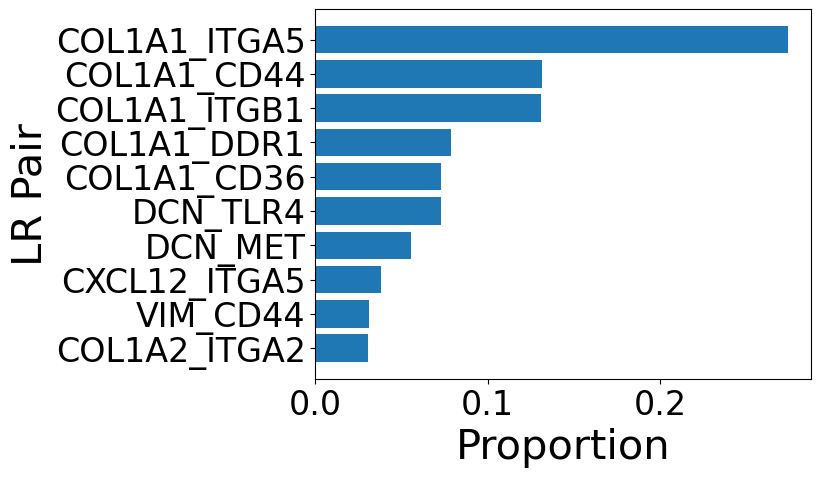

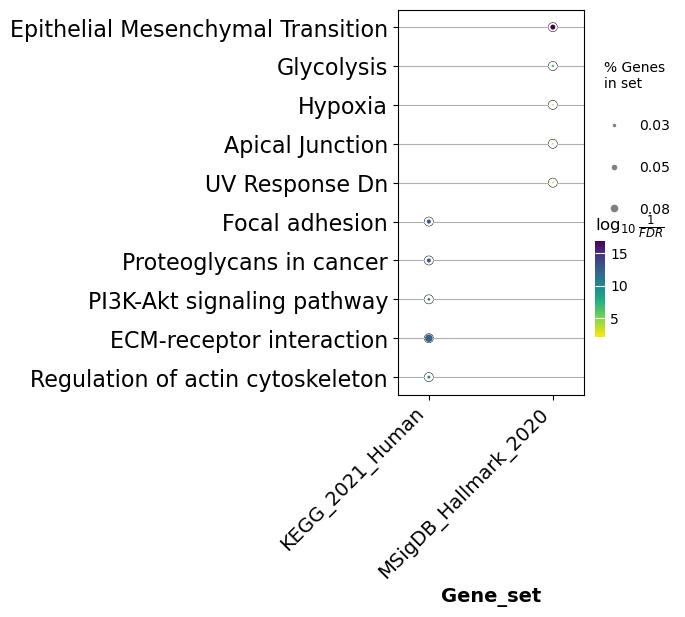

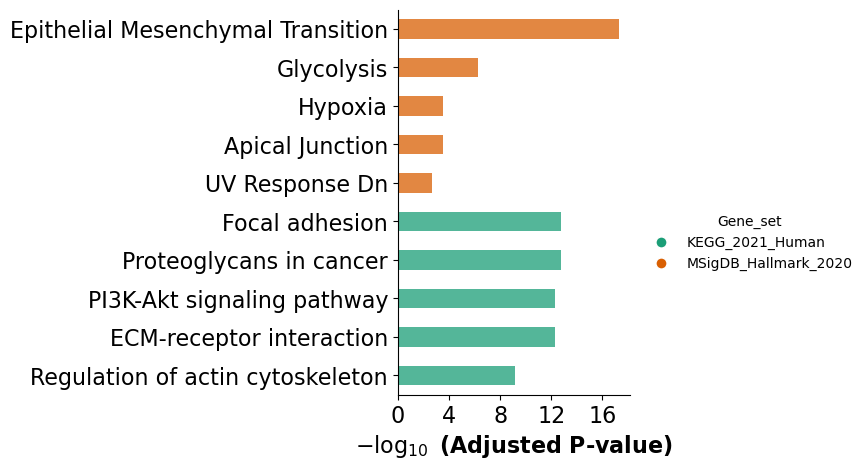

In [14]:
# mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "Endothelial")

n=10
pairs = mmcci.an.get_lrs_per_celltype(integrated, "Fibroblast", "Endothelial")
keys = list(pairs.keys())[:n]
values = list(pairs.values())[:n]
keys.reverse()
values.reverse()
plt.barh(keys, values)
plt.xlabel("Proportion", fontsize=30)  # Increase the font size of the x-axis label
plt.ylabel("LR Pair", fontsize=30)  # Increase the font size of the y-axis label
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase the font size of the tick labels

gene_list = set()

for lr in pairs:
    gene1, gene2 = lr.split("_")
    gene_list.add(gene1)
    gene_list.add(gene2)

gene_list = list(gene_list)

for gene in gene_list:
    print(gene)

mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

LTB
CCR10
IL2RA
ITGB2
TNFRSF1A
ICAM2
CD40
MRC1
CD4
LGALS1
CCR7
PTPRC
IL16
CCL19
LTBR
ICAM1
ICAM3


/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cytokine-cytokine receptor interaction,10/295,7.428980e-15,5.720315e-13,0,0,98.736842,3212.243972,CD40;CD4;IL2RA;IL16;CCR7;LTBR;LTB;CCL19;CCR10;...
1,KEGG_2021_Human,Cell adhesion molecules,7/148,1.924885e-11,7.410808e-10,0,0,98.506383,2430.504104,CD40;CD4;PTPRC;ITGB2;ICAM2;ICAM3;ICAM1
2,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,6/100,1.588407e-10,3.884832e-09,0,0,115.410058,2604.010888,IL2RA;CCR7;LTBR;CCL19;CCR10;TNFRSF1A
3,KEGG_2021_Human,NF-kappa B signaling pathway,6/104,2.018094e-10,3.884832e-09,0,0,110.677180,2470.723852,CD40;LTBR;LTB;CCL19;TNFRSF1A;ICAM1
4,KEGG_2021_Human,Human T-cell leukemia virus 1 infection,7/219,3.038107e-10,4.678684e-09,0,0,65.281604,1430.621307,CD40;CD4;IL2RA;ITGB2;LTBR;TNFRSF1A;ICAM1
...,...,...,...,...,...,...,...,...,...,...
86,MSigDB_Hallmark_2020,Xenobiotic Metabolism,1/200,1.571144e-01,1.571144e-01,0,0,6.213568,11.499956,TNFRSF1A
87,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,1/200,1.571144e-01,1.571144e-01,0,0,6.213568,11.499956,ICAM1
88,MSigDB_Hallmark_2020,KRAS Signaling Up,1/200,1.571144e-01,1.571144e-01,0,0,6.213568,11.499956,ITGB2
89,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,1.571144e-01,1.571144e-01,0,0,6.213568,11.499956,ITGB2


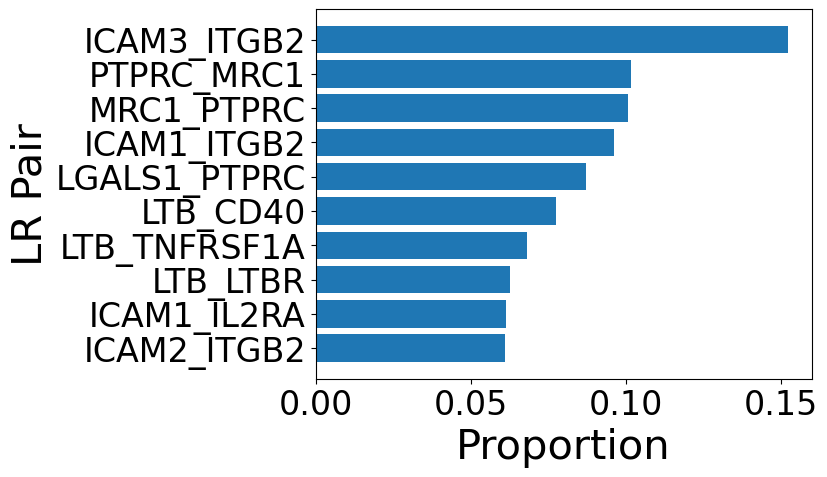

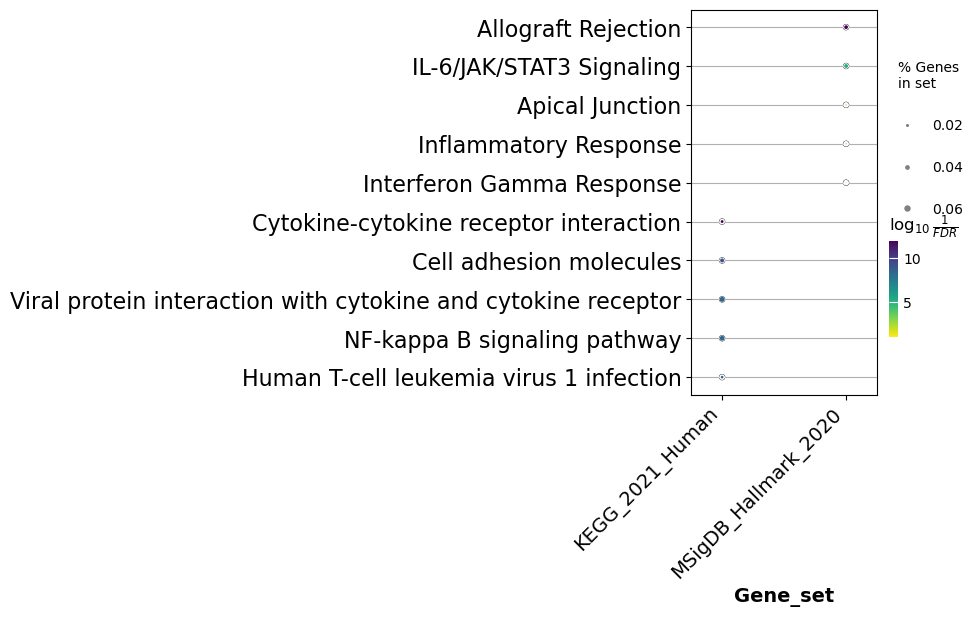

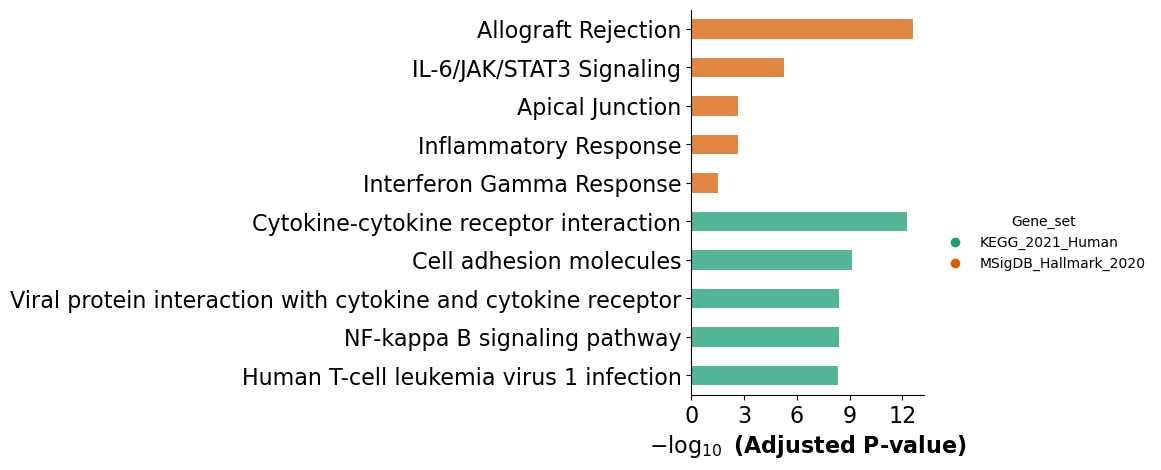

In [15]:
# mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "Endothelial")

n=10
pairs = mmcci.an.get_lrs_per_celltype(integrated, "NK + T", "Myeloid")
keys = list(pairs.keys())[:n]
values = list(pairs.values())[:n]
keys.reverse()
values.reverse()
plt.barh(keys, values)
plt.xlabel("Proportion", fontsize=30)  # Increase the font size of the x-axis label
plt.ylabel("LR Pair", fontsize=30)  # Increase the font size of the y-axis label
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase the font size of the tick labels

gene_list = set()

for lr in pairs:
    gene1, gene2 = lr.split("_")
    gene_list.add(gene1)
    gene_list.add(gene2)

gene_list = list(gene_list)

for gene in gene_list:
    print(gene)
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

MIF
CD74
CD93
CXCL12
C1QA
CD14
CCR7
ITGB1
CCL19
APP


/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Pertussis,3/76,0.000006,0.000293,0,0,116.929550,1401.960378,ITGB1;C1QA;CD14
1,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,3/100,0.000014,0.000293,0,0,87.892489,981.154450,CXCL12;CCR7;CCL19
2,KEGG_2021_Human,NF-kappa B signaling pathway,3/104,0.000016,0.000293,0,0,84.394625,932.167056,CXCL12;CD14;CCL19
3,KEGG_2021_Human,Chemokine signaling pathway,3/192,0.000099,0.001368,0,0,44.900227,413.791532,CXCL12;CCR7;CCL19
4,KEGG_2021_Human,Cytokine-cytokine receptor interaction,3/295,0.000353,0.003883,0,0,28.910959,229.814532,CXCL12;CCR7;CCL19
...,...,...,...,...,...,...,...,...,...,...
69,MSigDB_Hallmark_2020,Estrogen Response Early,1/200,0.095638,0.095638,0,0,11.050251,25.936965,CXCL12
70,MSigDB_Hallmark_2020,Estrogen Response Late,1/200,0.095638,0.095638,0,0,11.050251,25.936965,CXCL12
71,MSigDB_Hallmark_2020,Interferon Gamma Response,1/200,0.095638,0.095638,0,0,11.050251,25.936965,CD74
72,MSigDB_Hallmark_2020,Apical Junction,1/200,0.095638,0.095638,0,0,11.050251,25.936965,ITGB1


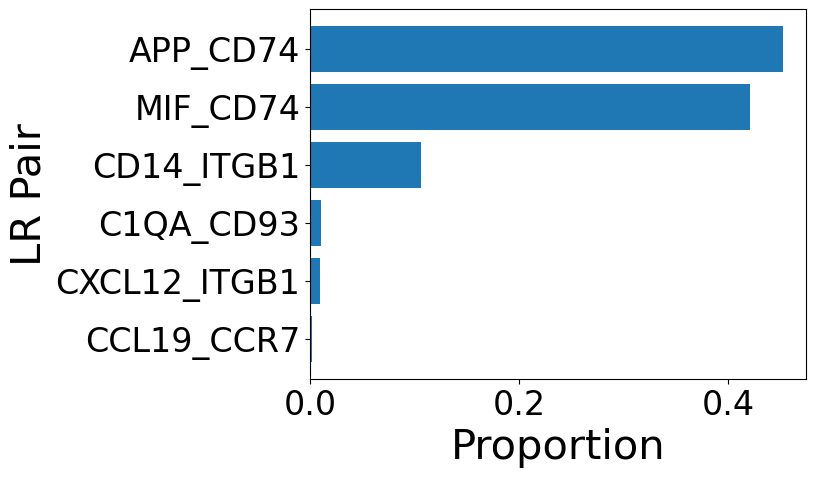

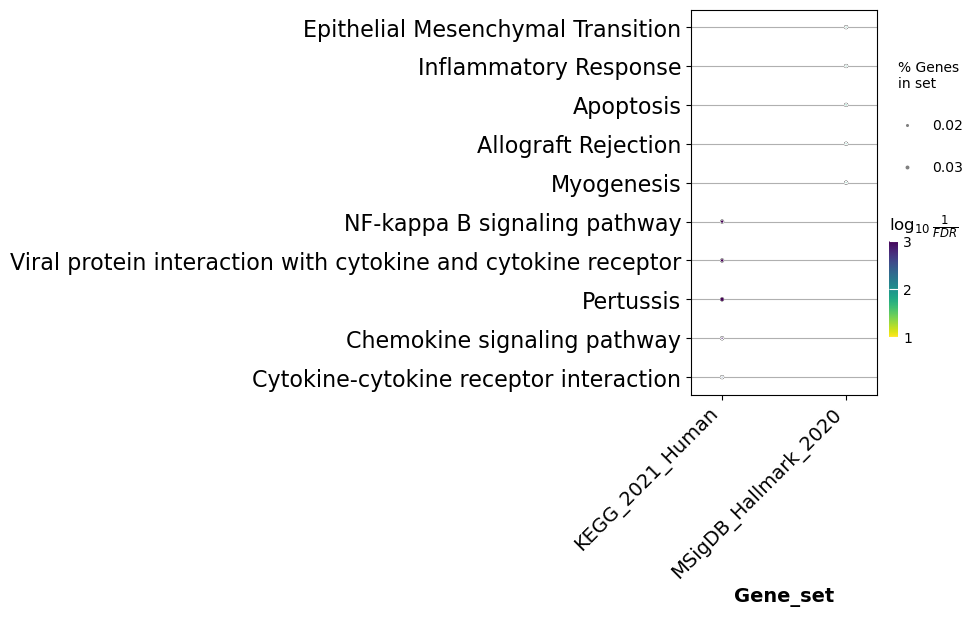

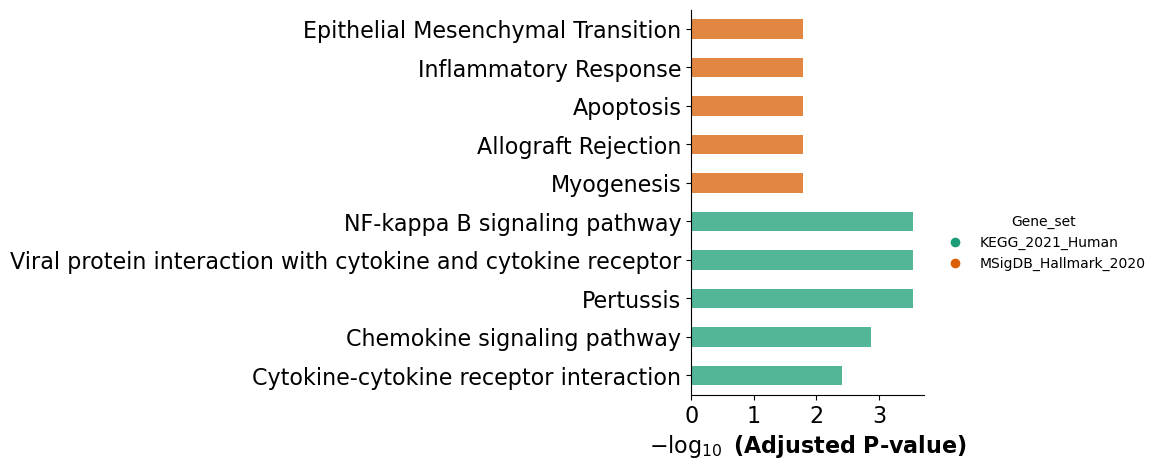

In [16]:
# mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "Endothelial")

n=10
pairs = mmcci.an.get_lrs_per_celltype(integrated, "Myeloid", "Endothelial")
keys = list(pairs.keys())[:n]
values = list(pairs.values())[:n]
keys.reverse()
values.reverse()
plt.barh(keys, values)
plt.xlabel("Proportion", fontsize=30)  # Increase the font size of the x-axis label
plt.ylabel("LR Pair", fontsize=30)  # Increase the font size of the y-axis label
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase the font size of the tick labels


gene_list = set()

for lr in pairs:
    gene1, gene2 = lr.split("_")
    gene_list.add(gene1)
    gene_list.add(gene2)

gene_list = list(gene_list)

for gene in gene_list:
    print(gene)
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

#### Cluster Aged and Young LR Pairs

In [52]:
import pickle

file_path = "/scratch/project/stseq/Levi/mmcci/mmcci_melanoma/integrated.pkl"

# Save the integrated object as a pickle file
with open(file_path, "wb") as file:
    pickle.dump(integrated, file)

In [56]:
import numpy as np
for lr, matrix in integrated.items():
    matrix = np.nan_to_num(matrix)
    if np.isnan(matrix).any():
        print("NaN values found in matrix for LR:", lr)


In [27]:
clusters = mmcci.an.lr_grouping(integrated, n_clusters=0)
integrated_clusters = mmcci.an.subset_clusters(integrated, clusters)
overall_clusters = mmcci.an.calculate_cluster_interactions(integrated_clusters)

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 53/53 [00:01<00:00, 46.41it/s]


Computing Principal Components of weighted graph ...


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [12]:
for cluster, matrix in overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)

NameError: name 'overall_clusters' is not defined

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 37/37 [00:00<00:00, 71.85it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


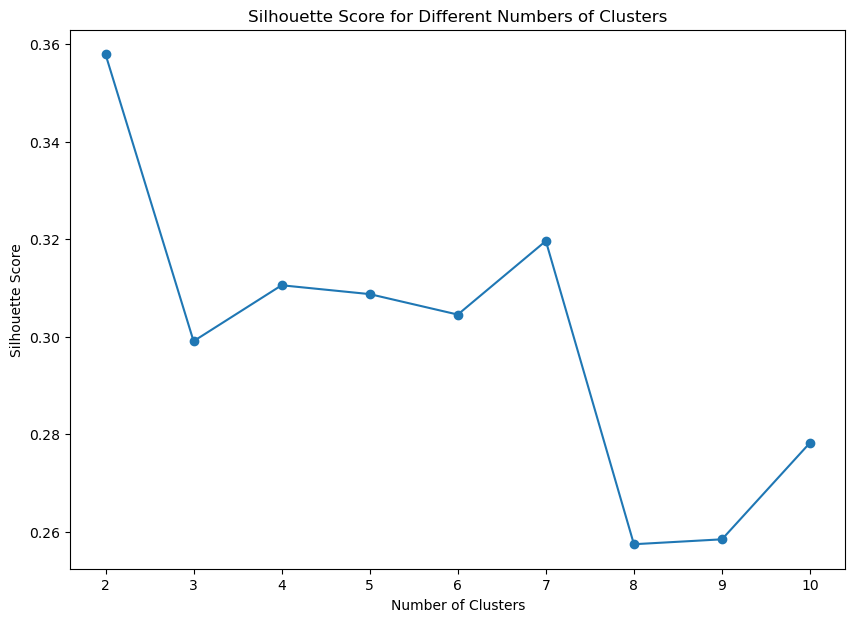

Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 98/98 [00:04<00:00, 22.95it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


In [ ]:
young_clusters = mmcci.an.lr_grouping(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.an.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.an.calculate_cluster_interactions(young_integrated_clusters)


cluster0: Contains 26 LR pairs


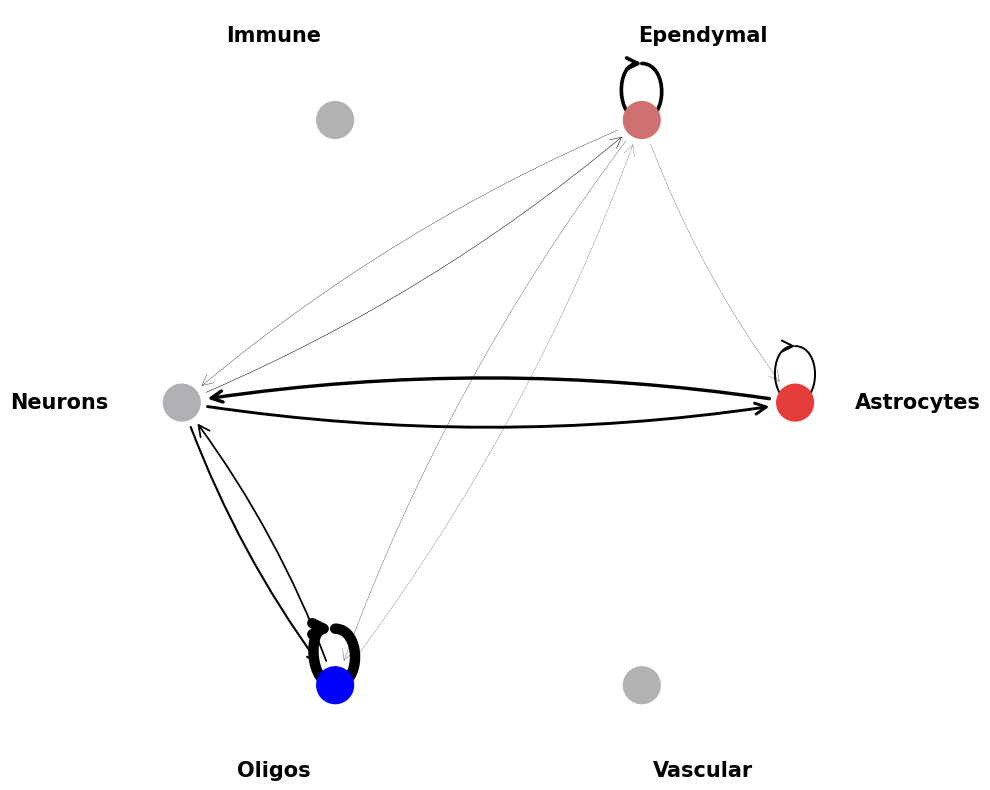


cluster1: Contains 11 LR pairs


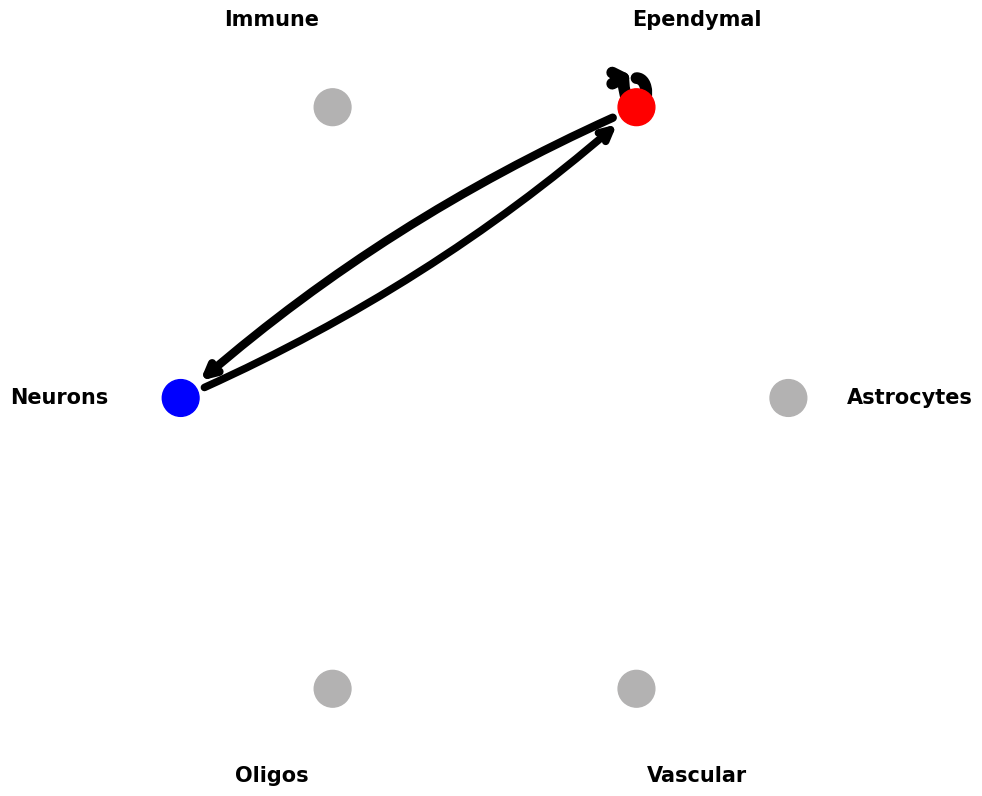


cluster2: Contains 37 LR pairs


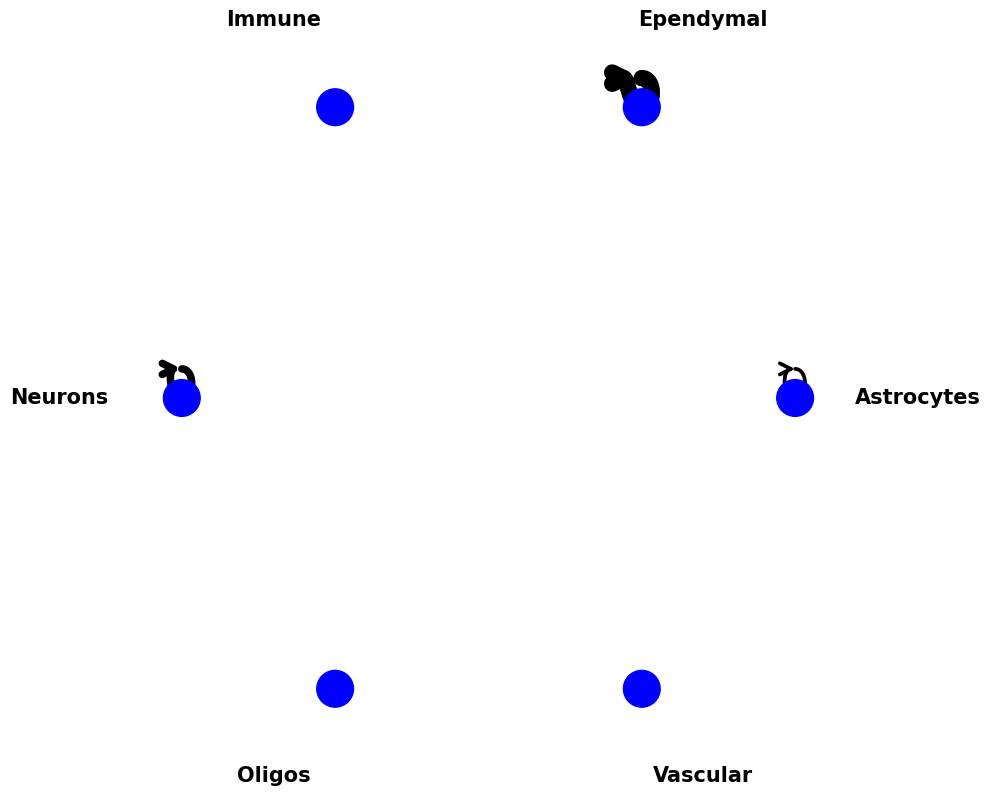


cluster3: Contains 61 LR pairs


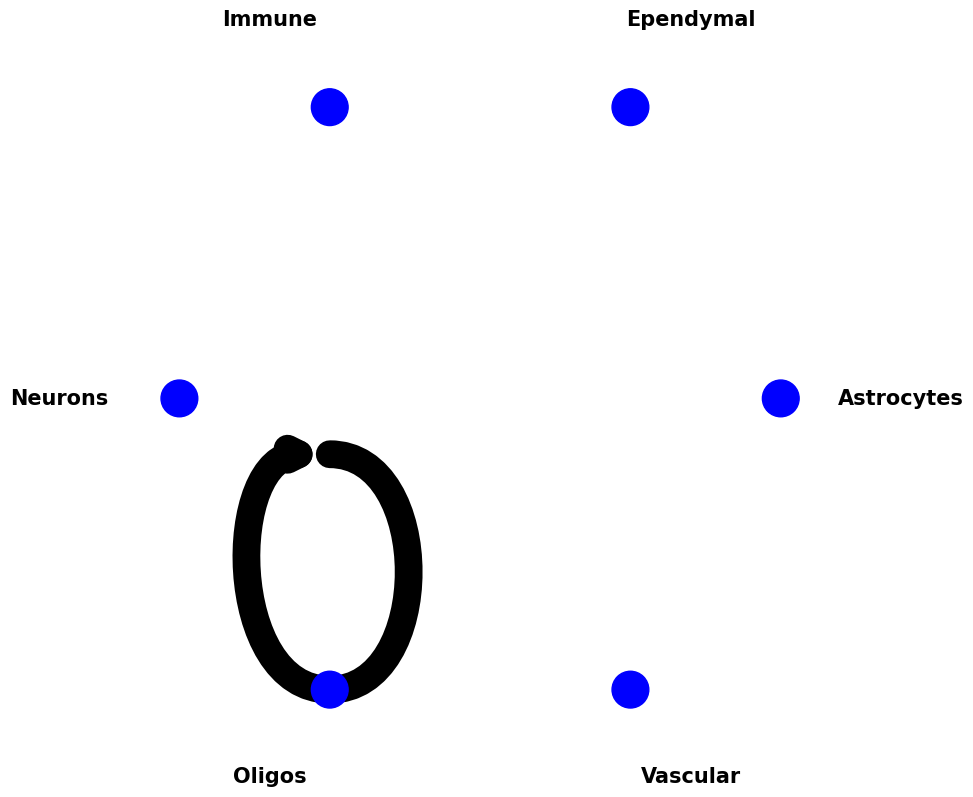

In [ ]:
for cluster, matrix in young_overall_clusters.items():
    if matrix is not None:
        print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
        mmcci.plt.network_plot(matrix)

#### Run GSEA Analysis on Clusters

/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,25/200,2.058022e-28,8.026285e-27,0,0,38.081081,2427.693193,NOTCH2;ITGB1;LRP1;SERPINE2;SDC4;LAMA2;LAMA1;FB...
1,MSigDB_Hallmark_2020,Angiogenesis,6/36,2.179519e-08,4.250063e-07,0,0,42.733333,753.883364,LRPAP1;VTN;LPL;ITGAV;VEGFA;FGFR1
2,MSigDB_Hallmark_2020,UV Response Dn,8/144,5.853843e-07,7.609996e-06,0,0,12.776341,183.353240,PDGFRB;COL1A1;NOTCH2;TGFBR3;COL1A2;FZD2;SDC2;CAV1
3,MSigDB_Hallmark_2020,Apoptosis,8/161,1.362950e-06,1.328876e-05,0,0,11.346980,153.250714,PDGFRB;TGFBR3;TGFB2;CAV1;BGN;PLAT;PSEN1;CD44
4,MSigDB_Hallmark_2020,Myogenesis,8/200,6.834697e-06,5.331064e-05,0,0,9.024267,107.330110,COL1A1;ITGB1;TGFB1;NOTCH1;LAMA2;PLXNB2;FGF2;HBEGF
...,...,...,...,...,...,...,...,...,...,...
195,KEGG_2021_Human,Human immunodeficiency virus 1 infection,1/212,6.527138e-01,6.693435e-01,0,0,0.952220,0.406233,GNAI2
196,KEGG_2021_Human,cAMP signaling pathway,1/216,6.596123e-01,6.721366e-01,0,0,0.934314,0.388771,GNAI2
197,KEGG_2021_Human,Thermogenesis,1/232,6.858755e-01,6.945028e-01,0,0,0.868893,0.327624,FGFR1
198,KEGG_2021_Human,Parkinson disease,1/249,7.115841e-01,7.160315e-01,0,0,0.808632,0.275147,GNAI2


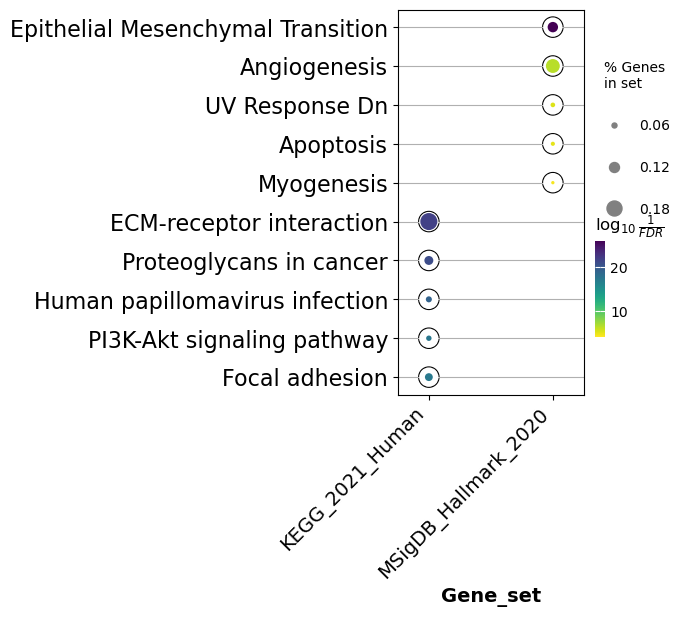

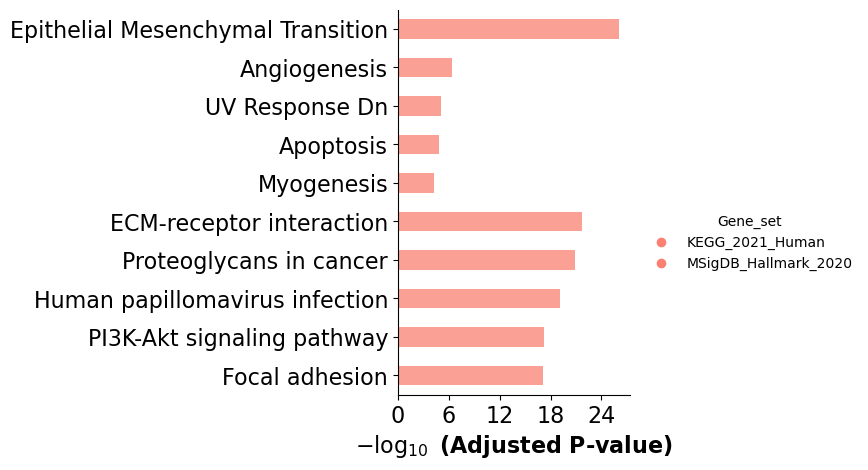

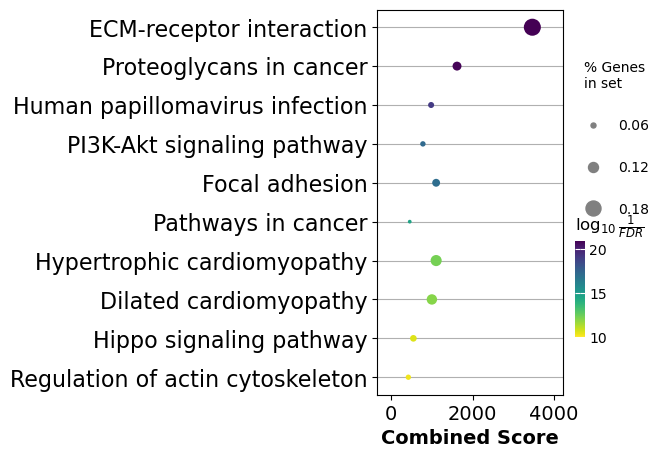

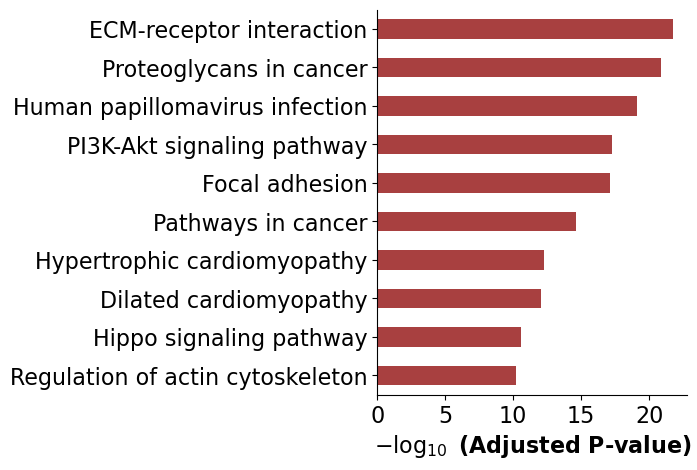

In [ ]:
aged_cluster_0_gsea = mmcci.an.run_gsea(aged_integrated_clusters[0])
aged_cluster_0_gsea